In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import datetime as dt
import scipy as sp

# Part 1. Prepare the dataset

- To facilitate the exploring process, Three tabs are extracted from the original `Bofa Data_USF.xlsx` file and saved as csv files: `BAC_Dates.csv`, `BofA_daily_volumes.csv`, and `BofA_monthly_volumnes.csv`. 
- Those three files are read using pandas DataFrame. 
- Regarding the `BAC_Dates.csv`, only the first two columns, `Key Dates` and `Topic`, were read. Other columns either contain links or nothing.

In [2]:
events = pd.read_csv('BAC_Dates.csv', encoding='cp1252')[['Key Dates', 'Topic']]
monthly = pd.read_csv('BofA_monthly_volumes.csv')
daily = pd.read_csv('BofA_daily_volumes.csv')

## Part 1.1 Standardize the column name

- Add a duration column in the `events` df
- Set the default duration to 1

In [3]:
events['duration'] = 1

For all three dfs:
- Standardize the columns' name
- Add name to unnamed columns
- Standardize dates columns

In [4]:
# Column names
events.columns = ['key_dates', 'topic', 'duration']
monthly.columns = ['months', 'monthly_volume','monthly_net_sentiment']
daily.columns = ['dates', 'daily_volume', 'daily_net_sentiment']

# Convert to datetime of the daily df
daily['dates'] = pd.to_datetime(daily['dates'])

## Part 1.2: Drop blank rows and impute missing `key_dates`

In [5]:
# Identify missing values for key_dates
events[events.key_dates.isnull()]

,key_dates,topic,duration
153,NaN,NaN,1
1250,NaN,NaN,1
1251,NaN,NaN,1
1256,NaN,A paradoy video that included footage from the...,1
1257,NaN,AOC shared this tweet and negatively commented...,1
1259,NaN,NaN,1


In [6]:
# Drop blank rows
events = events.drop([153, 1250, 1251, 1259])
events[events.key_dates.isnull()]

,key_dates,topic,duration
1256,NaN,A paradoy video that included footage from the...,1
1257,NaN,AOC shared this tweet and negatively commented...,1


The two events corresponding to the missing `key_dates` are Sep 22, 2022 according to the Twitter link attached in the excel file.

In [7]:
events.loc[1256, 'key_dates'] = '09/22/2022'
events.loc[1257, 'key_dates'] = '09/22/2022'

## Part 1.3: Standardize the `key_dates` columns in the `events` df

In [8]:
def multipleDateEvent(df):
    """
    output:
        date_l: a list of dates whose events last more than 1 day
    """
    date_l = []
    for date in df[df['key_dates'].notnull()]['key_dates']:
        if '&' in date or '-' in date or 'and' in date:
            date_l.append(date)
    return date_l

In [9]:
def validate(date_text):
    """
    input:
        date_text: a string date
    output:
        True: if the string can be converted to datetime format
        False: if the string can't be converted to datetime format
    """
    try:
        pd.to_datetime(date_text, infer_datetime_format=True)
        return True
    except ValueError:
        return False

In [10]:
def getStandardizedDates(multi_dates):
    """
    input:
        multi_dates: a string in the date_l that can't be converted to datetime format even after splitting
    output:
        standardized_date: a list of dates that is splitted and can be converted to datetime format
    """
    standardized_dates = []
    # Split the string by either - or & and assign it to a list
    date_split = re.split(r'[-&]|and', multi_dates)
    
    # If only the first string of the list can be converted to datetime format
    if validate(date_split[0]) == True and validate(date_split[1]) == False:
        
        # Append the year of the first string to the second string
        date_split[1] = date_split[1] + '/' + date_split[0].split('/')[-1]
    
    # If only the second string of the list can be converted to datetime format
    elif validate(date_split[0]) == False and validate(date_split[1]) == True :
        
        # Append the year of the second string to the first string
        date_split[0] = date_split[0] + '/' + date_split[1].split('/')[-1]
    
    # return the editted list
    # Remove any blank space around the dates
    standardized_dates = [date_split[0].strip(), date_split[1].strip()]
    return standardized_dates

In [11]:
def updateDuration(events, date_l):
    """
    Update the duration and key_dates
    ----------
    input:
        events: the `events` df
        date_l: list of string dates that have multiple dates
    output:
        events: events df with adjusted duration and key_dates
    """
    
    # Iterate through every rows of the dataframe       
    for index, row in events.iterrows():
        
        # Check if the key_dates of that rows is in the special date_l:
        if row['key_dates'] in date_l:
            
            # Get a list of standardized dates
            standardized_dates = getStandardizedDates(row['key_dates'])

            # If the format of both days in the standardized_dates list is valid
            if validate(standardized_dates[0]) and validate(standardized_dates[1]):

                # Compute the time difference between the two dates
                # Assign the adjusted different to the duration column
                events.loc[index, 'duration'] = (pd.to_datetime(standardized_dates[1], infer_datetime_format=True) - \
                                           pd.to_datetime(standardized_dates[0], infer_datetime_format=True)).days + 1
                
                # Assign the first standardized date to the key_dates columns
                events.loc[index, 'key_dates'] = standardized_dates[0] + '&' + standardized_dates[1]
    return events

In [12]:
def removeSecondKeyDates(events, date_l):
    """
    Remove the second dates in the list of events with multiple_dates
    ------------
    input:
        events: the `events` df
        date_l: list of string dates that have multiple dates
    output:
        events: `events` df with the second dates in `key_dates` removed   
    """
    # Iterate through every rows of the dataframe       
    for index, row in events.iterrows():
        
        # Check if the key_dates of that rows is in the special date_l:
        if row['key_dates'] in date_l:
            
            # Get a list of standardized dates
            standardized_dates = getStandardizedDates(row['key_dates'])

            # If the format of both days in the standardized_dates list is valid
            if validate(standardized_dates[0]) and validate(standardized_dates[1]):

                # Assign the first standardized date to the key_dates columns
                events.loc[index, 'key_dates'] = standardized_dates[0]
    return events

Update the `events` 1st time:
- Update rows in the `duration` columnn, whose `key_dates` can be converted to datetime format
- Update rows in the `key_dates`column that can be converted to datetime format 

In [13]:
# Get duration whose key_dates can be converted to datetime format
events = updateDuration(events, multipleDateEvent(events))

The `event` after updating the first time. 

In [14]:
events[events['key_dates'].isin(multipleDateEvent(events))].head(10)

,key_dates,topic,duration
36,6/3/2011&6/6/11,Florida Homeowner Forecloses on BAC Branch \n,4
68,9/30/2011&10/3/2011,BAC Online Banking Outage,4
106,2/1/2012&2/3/2012,2012 Chicago Marathon Registration Begins; Fac...,3
176,9/18/2012&9/19/2012,Bank Of America Website Slows After Islamic Ha...,2
297,8/2&8/3,BAC: Justice Department Intends To File Civil ...,1
357,1/30 - 2/4,Harvard Economist Withdraws $1M,1
361,2/6/2014&2/7/14,Lisa McIntire Credit Card incident,2
401,5/12-5/16,GAP Belfast,1
517,6/8/2015&6/9/15,"McKinney, TX Contractor Incident",2
561,12/1-12/13,Paris Climate Summit,1


The `duration` of events that last multiple dates can't be 1. Thus, there is some problem with rows at `key_dates` whose `duration` is 1. 

In [15]:
events[events['key_dates'].isin(multipleDateEvent(events)) & (events['duration'] == 1)]

,key_dates,topic,duration
297,8/2&8/3,BAC: Justice Department Intends To File Civil ...,1
357,1/30 - 2/4,Harvard Economist Withdraws $1M,1
401,5/12-5/16,GAP Belfast,1
561,12/1-12/13,Paris Climate Summit,1
671,11/29 &12/1,BofA #GivingTuesday Activities,1
702,2/7&2/8,BofA opens branches without employees,1
726,4/3-4/5,BofA campaign with Dodgers,1
728,4/12-4/13,Android Pay now works with BofA,1
750,6/1&6/2,Michelle Moore named Digital Banker of the year,1
754,6/12-6/13,Shakespeare Play Sponsorship,1


You can see that the these are `key_dates` that miss the year part. We can manually add the year to those `key_dates` because the `key_dates` are ordered chronologically so we could determine the year based on `key_dates` around it. For example, at the index 297, we can see that rows around that has the year of 2013. Therefore, we could add 2013 at the end of the cell at index 297

In [16]:
events.iloc[292:305,:]

,key_dates,topic,duration
293,7/18/2013,Bank of America's Recipe for Getting Away with...,1
294,7/25/2013,Merrill Lynch Accused Of Telling Women To Sedu...,1
295,7/29/2013,LEED Lies: Bank Of America’s “Green” Skyscrape...,1
296,7/31/2013,Judge Rejects Fed’s Cap on Debit Card Fees\n,1
297,8/2&8/3,BAC: Justice Department Intends To File Civil ...,1
298,8/6/2013,US government sues Bank of America over mortga...,1
299,8/12/2013,"Bank Of America Continues Deducting Fees, Even...",1
300,8/16/2013,Bank of America May Merge Merrill Lynch With P...,1
301,8/16/2013,"Bank of America rose 13 cents, or 1 percent, t...",1
302,8/20/2013,Untimely death of BAML Intern,1


Update the `key_dates` for all the index whose rows have no year associated to it

In [17]:
events.loc[297, 'key_dates'] += '/2013'
events.loc[357, 'key_dates'] += '/2014'
events.loc[401, 'key_dates'] += '/2014'
events.loc[561, 'key_dates'] += '/2015'
events.loc[671, 'key_dates'] += '/2016'
events.loc[702, 'key_dates'] += '/2017'
events.loc[726, 'key_dates'] += '/2017'
events.loc[728, 'key_dates'] += '/2017'
events.loc[750, 'key_dates'] += '/2017'
events.loc[754, 'key_dates'] += '/2017'
events.loc[763, 'key_dates'] += '/2017'
events.loc[1098, 'key_dates'] += '/2020'
events.loc[1115, 'key_dates'] += '/2020'


Update the `events` df the 2nd time after adding the year parts

In [18]:
events = updateDuration(events, multipleDateEvent(events))

There are some events, whose `duration` last more than 30 days. This is unusual. When analyzing these dates, it seems that the input format for date is `%d/%m/%y`, not `%m/%d/%y` that is used in the U.S. Check for dates with the format `%d/%m/%y`

In [19]:
events[events['key_dates'].isin(multipleDateEvent(events)) & (events['duration'] > 30)]

,key_dates,topic,duration
787,07/09/2017&08/09/2017,BofA extending contactless options with FitPay,32
788,07/09/2017&08/09/2017,#VietnamwarPBS,32
831,04/01/18&05/01/18,Tweet re: Tax cut wage increases,31
850,03/03/18&04/03/18,Tweet re: Planned Parenthood donors,32
865,07/05/18&08/05/18,BofA loan to Remington,32


Change the format of `key_dates` from %d/%m/%y to %m/%d/%y

In [20]:
# Get the df that has the date format of %d/%m/%y
wrong_format = events[events['key_dates'].isin(multipleDateEvent(events)) & (events['duration'] > 30)]

# Iterate through every rows in the wrong_format df      
for index, row in wrong_format.iterrows():

    # Get a list of standardized dates
    standardized_dates = re.split(r'[-&]|and', row['key_dates'])

    # Get the date in the `%d/%m/%y`format
    formatted_first_date = standardized_dates[0].split('/')
    formatted_second_date = standardized_dates[1].split('/')
    formatted_first_date = formatted_first_date[1] + '/' + formatted_first_date[0] + '/' + formatted_first_date[2]
    formatted_second_date = formatted_second_date[1] + '/' + formatted_second_date[0] + '/' + formatted_second_date[2]

    # Update the `key_dates` column of the `events` df
    events.loc[index, 'key_dates'] = formatted_first_date + '&' + formatted_second_date                      

In [21]:
events[events['key_dates'].isin(multipleDateEvent(events)) & (events['duration'] > 30)]

,key_dates,topic,duration
787,09/07/2017&09/08/2017,BofA extending contactless options with FitPay,32
788,09/07/2017&09/08/2017,#VietnamwarPBS,32
831,01/04/18&01/05/18,Tweet re: Tax cut wage increases,31
850,03/03/18&03/04/18,Tweet re: Planned Parenthood donors,32
865,05/07/18&05/08/18,BofA loan to Remington,32


Update the `duration` the 3rd time

In [22]:
events = updateDuration(events, multipleDateEvent(events))

Fix other wrong date:
- The `key_dates` at index 378 is '3/11,13'. -> Let's change it to 3/11/13
- The `key_dates` at index 390 is '4/4/2014 (reposted from 3/25)'. -> Let's change it to 4/4/2014
- The `key_dates` at index 578 has the year 2006 -> Let's change it to 2016


In [23]:
events.loc[378, 'key_dates'] = '3/11/13'
events.loc[390, 'key_dates'] = '4/4/2014'
events.loc[578, 'key_dates'] = '3/3/2016'

Remove the second dates in the list of events with multiple_dates and standardize the date format

In [24]:
events = removeSecondKeyDates(events, multipleDateEvent(events))
events['key_dates'] = pd.to_datetime(events['key_dates'], infer_datetime_format=True)

C:\Users\Kha Do\AppData\Local\Temp\ipykernel_13464\1781597860.py:2: UserWarning: Parsing '16/09/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  events['key_dates'] = pd.to_datetime(events['key_dates'], infer_datetime_format=True)


## Part 1.4: Change column data types

In [25]:
daily.dtypes

dates                  datetime64[ns]
daily_volume                   object
daily_net_sentiment           float64
dtype: object

In [26]:
daily.daily_volume = daily.daily_volume.apply(lambda x: int(x.replace(',','')))

## Part 1.5: Join the dataset

To facilitate the analysis, join the `events` df and the `daily` df

In [139]:
df = daily.merge(events, how='outer', left_on='dates', right_on='key_dates')
df = df.drop('key_dates', axis=1)

Add a column named `important` to easily identify important events in the joined dataset

In [141]:
df['important'] = 0
df.loc[df.topic.notnull(), 'important'] = 1
df['year'] = df.dates.dt.year
df['month'] = df.dates.dt.month

In [142]:
df

,dates,daily_volume,daily_net_sentiment,topic,duration,important,year,month
0,2011-01-01,1050.0,-1.8,NaN,NaN,0,2011.0,1.0
1,2011-01-02,1019.0,-2.7,NaN,NaN,0,2011.0,1.0
2,2011-01-03,5151.0,-2.1,BAC Sets Up WikiLeaks Defense Team ; BAC elimi...,1.0,1,2011.0,1.0
3,2011-01-04,3517.0,-3.0,NaN,NaN,0,2011.0,1.0
4,2011-01-05,2225.0,-2.4,NaN,NaN,0,2011.0,1.0
...,...,...,...,...,...,...,...,...
4484,2022-11-24,4644.0,-2.9,NaN,NaN,0,2022.0,11.0
4485,2022-11-25,4233.0,-4.5,NaN,NaN,0,2022.0,11.0
4486,2022-11-26,5320.0,-4.9,New post critical of the Community Affordable ...,1.0,1,2022.0,11.0
4487,2022-11-27,3797.0,-4.2,NaN,NaN,0,2022.0,11.0


# Part 2: Explore the dataset

## Part 2.1: Volume

Important events clearly have more traffic than the normal events

In [143]:
print('Mean daily volume for events with important == 0:', df.groupby('important')['daily_volume'].mean()[0])
print('Mean daily volume for events with important == 1:', df.groupby('important')['daily_volume'].mean()[1])
_,pvalue = sp.stats.ttest_ind(a=df[df.important == 0]['daily_volume'], \
                   b=df[df.important == 1]['daily_volume'], nan_policy='omit')
print('P value: {:0.4f}'.format(pvalue))
px.line(df, x='dates', y='daily_volume', color='important', title='Daily Volume over 10 years')

Mean daily volume for events with important == 0: 4852.489295687248
Mean daily volume for events with important == 1: 7700.897233201581
P value: 0.0000


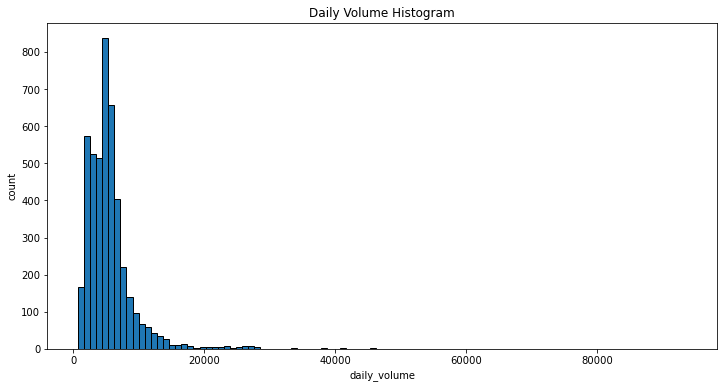

In [144]:
plt.figure(figsize=(12,6))
plt.hist(df.daily_volume, bins=100, edgecolor='black')
plt.title('Daily Volume Histogram')
plt.xlabel('daily_volume')
plt.ylabel('count')
plt.show()

These 12 events have the highest `daily_volume`

In [145]:
df.sort_values(by='daily_volume', ascending=False).head(12)

,dates,daily_volume,daily_net_sentiment,topic,duration,important,year,month
2448,2017-06-12,93581.0,1.7,Shakespeare Play Sponsorship,2.0,1,2017.0,6.0
4172,2022-01-23,92614.0,2.4,Employee issue and positive reaction to bank's...,1.0,1,2022.0,1.0
2684,2018-01-23,87126.0,-4.6,NaN,NaN,0,2018.0,1.0
3497,2020-04-03,73348.0,-1.7,President Trump tweets thank you to the bank o...,1.0,1,2020.0,4.0
2683,2018-01-22,58779.0,-3.8,BofA to charge for eBanking accounts,3.0,1,2018.0,1.0
4218,2022-03-10,54907.0,-4.3,NaN,NaN,0,2022.0,3.0
4289,2022-05-18,53563.0,-3.1,BofA logo in background of NYU commencement wi...,1.0,1,2022.0,5.0
2685,2018-01-24,51841.0,-4.2,NaN,NaN,0,2018.0,1.0
4397,2022-09-01,48817.0,-3.0,NaN,NaN,0,2022.0,9.0
2686,2018-01-25,47011.0,1.9,#WEF2018,2.0,1,2018.0,1.0


Correlation between variables and `daily_volume`

Correlation between variables and daily_volume:

important              0.261533
year                   0.226396
duration               0.106288
daily_net_sentiment    0.064366
month                 -0.034621
Name: daily_volume, dtype: float64


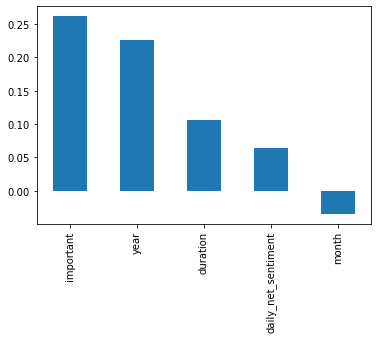

In [152]:
print('Correlation between variables and daily_volume:\n')
print(df.corr().daily_volume.sort_values(ascending=False)[1:])
df.corr().daily_volume.sort_values(ascending=False)[1:].plot(kind='bar')
plt.show()

Is there a trend between `year` and `daily_volume`

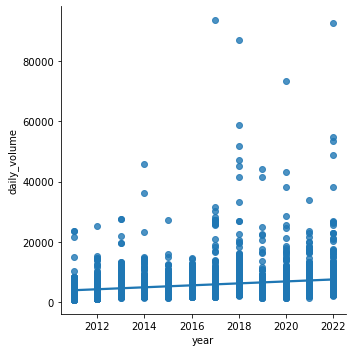

In [170]:
sns.lmplot(data=df, x='year', y='daily_volume')

Daily volume peaks in 2018. What happened in 2018?

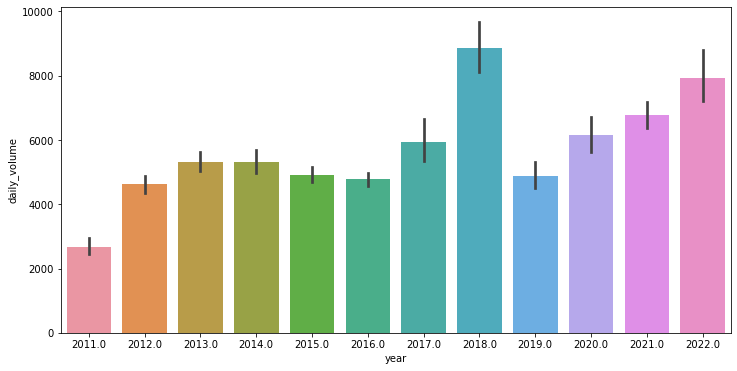

In [147]:
plt.figure(figsize=(12,6))
sns.barplot(x=df.year, y=df.daily_volume)
plt.show()

Top daily_volume in 2018. There are a lot of null values since events are not in the key_events list. We might need to use other tools to impute these null values

In [155]:
df[df.year==2018].sort_values(by='daily_volume', ascending=False).head(20)

,dates,daily_volume,daily_net_sentiment,topic,duration,important,year,month
2684,2018-01-23,87126.0,-4.6,NaN,NaN,0,2018.0,1.0
2683,2018-01-22,58779.0,-3.8,BofA to charge for eBanking accounts,3.0,1,2018.0,1.0
2685,2018-01-24,51841.0,-4.2,NaN,NaN,0,2018.0,1.0
2686,2018-01-25,47011.0,1.9,#WEF2018,2.0,1,2018.0,1.0
2763,2018-04-11,45326.0,1.6,NaN,NaN,0,2018.0,4.0
2762,2018-04-10,41491.0,3.8,BofA to stop lending money to military-style g...,2.0,1,2018.0,4.0
2906,2018-08-31,33254.0,-4.8,NaN,NaN,0,2018.0,8.0
2687,2018-01-26,26911.0,1.1,NaN,NaN,0,2018.0,1.0
2764,2018-04-12,26859.0,-3.3,NaN,NaN,0,2018.0,4.0
2905,2018-08-30,22594.0,-4.8,Various news agencies report of BoA freezing a...,2.0,1,2018.0,8.0


Events that has highest daily_volume in 2018 lies in the first 6 months. It peaked in January

<AxesSubplot:xlabel='month'>

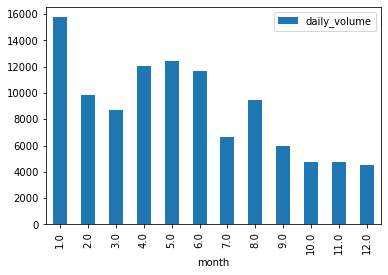

In [149]:
df[df.year==2018].groupby('month').daily_volume.mean().reset_index().plot(kind='bar', x='month', y='daily_volume')

What about 2022?

In [154]:
df[df.year==2022].sort_values(by='daily_volume', ascending=False).head(20)

,dates,daily_volume,daily_net_sentiment,topic,duration,important,year,month
4172,2022-01-23,92614.0,2.4,Employee issue and positive reaction to bank's...,1.0,1,2022.0,1.0
4218,2022-03-10,54907.0,-4.3,NaN,NaN,0,2022.0,3.0
4289,2022-05-18,53563.0,-3.1,BofA logo in background of NYU commencement wi...,1.0,1,2022.0,5.0
4397,2022-09-01,48817.0,-3.0,NaN,NaN,0,2022.0,9.0
4173,2022-01-24,38075.0,4.6,Employee issue and positive reaction to bank's...,1.0,1,2022.0,1.0
4442,2022-10-13,26733.0,-4.9,NaN,NaN,0,2022.0,10.0
4294,2022-05-23,26672.0,-3.5,World Economic Forum,1.0,1,2022.0,5.0
4295,2022-05-23,26672.0,-3.5,BofA boosts minimum wage to $22/hr at end of June,1.0,1,2022.0,5.0
4462,2022-11-02,26192.0,-4.2,Dan Snyder Hires Bank Of America To Sell Washi...,1.0,1,2022.0,11.0
4441,2022-10-12,25696.0,-4.9,Virual tweet regarding a customer account closure,1.0,1,2022.0,10.0


Let's build a machine learning model to predict daily volume

In [191]:
ml_df = df.drop(['topic', 'duration'], axis=1).iloc[:-1, :-2]

In [220]:
# Change the date to train the model




In [201]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [202]:
X = ml_df.drop('daily_volume', axis=1)
y = ml_df['daily_volume'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y)

The model is terrible

In [203]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('Root mean squared error:',np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2 score:',r2_score(y_test, y_pred))

Root mean squared error: 4296.022993435972
r2 score: 0.025840743412266387


## Part 2.2: `daily_net_sentiment`

In [221]:
df

,dates,daily_volume,daily_net_sentiment,topic,duration,important,year,month
0,2011-01-01,1050.0,-1.8,NaN,NaN,0,2011.0,1.0
1,2011-01-02,1019.0,-2.7,NaN,NaN,0,2011.0,1.0
2,2011-01-03,5151.0,-2.1,BAC Sets Up WikiLeaks Defense Team ; BAC elimi...,1.0,1,2011.0,1.0
3,2011-01-04,3517.0,-3.0,NaN,NaN,0,2011.0,1.0
4,2011-01-05,2225.0,-2.4,NaN,NaN,0,2011.0,1.0
...,...,...,...,...,...,...,...,...
4484,2022-11-24,4644.0,-2.9,NaN,NaN,0,2022.0,11.0
4485,2022-11-25,4233.0,-4.5,NaN,NaN,0,2022.0,11.0
4486,2022-11-26,5320.0,-4.9,New post critical of the Community Affordable ...,1.0,1,2022.0,11.0
4487,2022-11-27,3797.0,-4.2,NaN,NaN,0,2022.0,11.0
